# Glacier Dynamics Assumptions Initialization 

In our task of initializing steady state configurations for our nine test glaciers, we must make some assumptions about glacier dynamics. Namely, we must:  
  1. assume a value for rate-factor $A$ and   
  2. make an assumption about slip along the basal boundary. 
  
While in later experiment we will account for the thermo-mechanical effects of ice flow, we preform mass balance related parameter tuning assuming isothermal conditions with a rate-factor $A$ for temperate ice from _Cuffey and Paterson, 2010_. For the basal boundary condition, our initial inclination is assume no sliding for all our input glaciers. We seek to first, asses how reasonable of an assumption no sliding is for each glacier, and second, determine the optimal value for the slip coefficient if the no slip assumption proves to be unreasonable. 

### Observational Surface Velocities 

We use the [ITS_LIVE](https://its-live.jpl.nasa.gov/) 120 m annually averaged mosaics, extracted along each glacier flowline to produce a reference (observational) velocity profiles for each glacier. These reference velocity profile are then compared to diagnostic surface velocities produced with Elmer/Ice. 

In [206]:
import re
import os
import glob
import rasterio
import numpy as np
import xarray as xr
import geopandas as gpd
import scipy.signal as signal
from scipy import interpolate
import matplotlib.pyplot as plt 

class flowline:
    """Class for easy extraction of shapefile to 
        flowline prodcut which can be used for Elmer geometry generation
    """
    
    def __init__(self, FL_shape):
        self.fp      = FL_shape
        self.shp_gdf = gpd.read_file(FL_shape)

    def shp_2_coords(self, dx=30):
        """Convert .shp line to discrete points spaced at specified dx.

        For reference see:
            https://stackoverflow.com/a/35025274/10221482
        """
        num_vert = int(round(self.shp_gdf.length[0] / dx))
        if num_vert == 0:
            num_vert = 1
        multipoint = [self.shp_gdf.interpolate(float(n)/num_vert,normalized=True) for n in range(num_vert + 1)]
        x_points = [multipoint[i].x[0] for i in range(len(multipoint))]
        y_points = [multipoint[i].y[0] for i in range(len(multipoint))]

        return [(x,y) for x,y in zip(x_points, y_points)]
    
    def shp_2_xarray(self, dx=30): 
        
        coords = self.shp_2_coords(dx=dx)
        
        x = xr.DataArray(np.array(coords)[:,0], dims="z")
        y = xr.DataArray(np.array(coords)[:,1], dims="z")
        # distance along flowline array
        d = xr.DataArray(np.arange(len(coords))*dx, dims="z")
        
        return x, y, d
    
    
class sampler:
    def __init__(self, src_fp):
        self.fp  = src_fp

    def extract(self, coords, dx):
        with rasterio.open(self.fp) as src:
            prof = [x[0] for x in src.sample(coords)]
            
            prof = np.where(np.array(prof)==src.nodata, np.nan, prof)
            
        return np.hstack([ np.arange(len(coords))[:,np.newaxis] * dx,
                           np.array(prof)[:, np.newaxis] ])



In [ ]:
# The glaciers of interest that we want the Farinotti Beds for.
RGI_IDs=("01.16121",    # Tweedsmuir    Glacier
         "01.16122",    # Fisher        Glacier
         "01.16262",    # Spring        Glacier
         "01.17183",    # Klutlan       Glacier
         "01.16198-LK", # Little Kluane Glacier
         "01.16198-BK", # Kluane        Glacier
         "01.16195",    # South         Glacier
         "01.16855",    # Glacier #18 from Crompton studies
         "01.16732",    # Glacier #13 from Crompton studies
         )

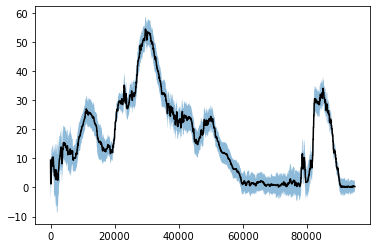

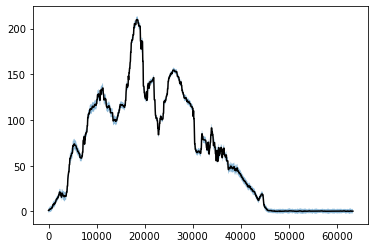

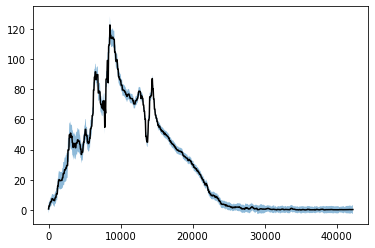

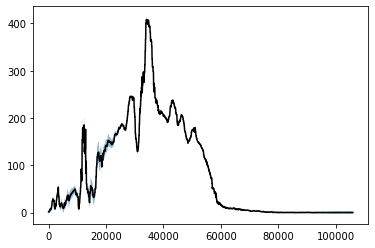

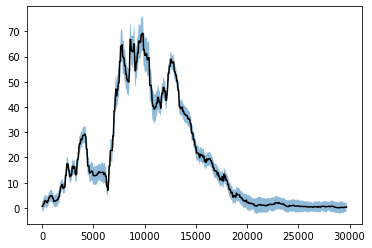

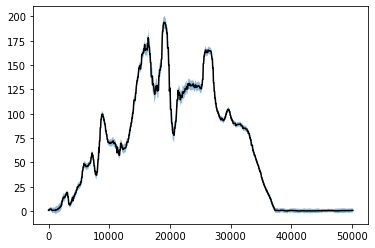

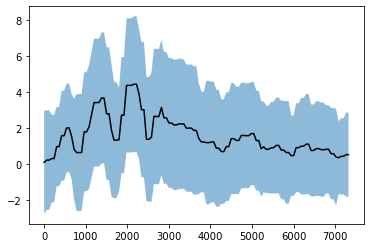

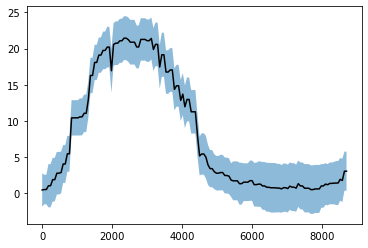

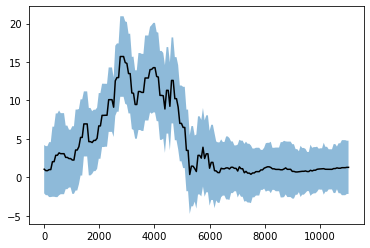

In [216]:
base_fp = "/Users/andrewnolan/Desktop/Big_Glaciers/Glaciers/"

v_m   = sampler('ALA_G0120_0000_v_UTM7N.tif')
v_err = sampler('ALA_G0120_0000_v_err_UTM7N.tif')


# Loop of the RGI_IDs
for RGI_ID in RGI_IDs:
    # create glob string to find all flowlines in the manual flowlines
    # directory. There will often be more than one (i.e. flowine a versus b)
    dir_fp = os.path.join(base_fp, 
             "RGI60-{}/Manual_FL/Manual_FL-{}*.shp".format(*[RGI_ID,]*2))
    for i, fl_fp in enumerate(glob.glob(dir_fp)): 
        # Only deal with main flowlines now, not secondary flowlines
        if all([True if sub not in fl_fp else False for sub in ['-2.shp', '-S.shp', '_old.shp']]):
            # initialize the flowline using our defined class
            FL  = flowline(fl_fp)
        
            # extract discretized flowline information from shapefile
            coords = flowline(fl_fp).shp_2_coords(60)
            
            velocity = v_m.extract(coords, 60)
            error    = v_err.extract(coords, 60)
            
            fig, ax = plt.subplots()
            ax.fill_between(velocity[:,0],velocity[:,1]-10*error[:,1],velocity[:,1]+10*error[:,1], alpha=0.5)
            ax.plot(velocity[:,0], velocity[:,1], c='k')



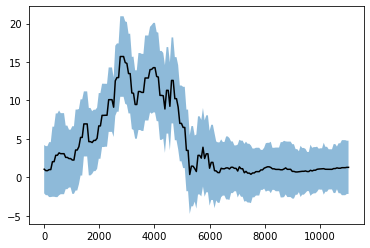

In [217]:
velocity = v_m.extract(coords, 60)
error    = v_err.extract(coords, 60)

plt.fill_between(velocity[:,0],velocity[:,1]-10*error[:,1],velocity[:,1]+10*error[:,1], alpha=0.5)
plt.plot(velocity[:,0], velocity[:,1], c='k')

plt.savefig("test.png",dpi=600)

In [218]:
with rasterio.open(v_m.fp) as src:
    prof = [x[0] for x in src.sample(coords)]